# **Reference Curves for Skin Friction Coefficient**

In [1]:
#!/usr/bin/env python
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# increase dpi and use latex rendering
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 160
mpl.rc('text', usetex=True)

# Set macro for paths
run = "../run/"
!mkdir -p output

## **1. Setup the Related Values**
'*nuInf*' is calculated from the literature of *Wieghardt* (1944) with the 5m plate and Re = 10^7.

In [2]:
# nuInf1 = 5*17.8/10^7
UInf1 = 17.8
nuInf1 = 8.9e-06

# nuInf2 = 5*33.0/10^7
UInf2 = 33.0
nuInf2 = 1.65e-05

## **2. Load data to show *Wieghardt* plot in **OpenFOAM****

In [3]:
UInf = 69.4
nuInf = 1.388e-05
model = "kOmegaSST"
yp = ['0.05', '1', '2', '5', '10', '30', '50', '100']
res_list = ['1e-3', '1e-4', '1e-5', '1e-6']

tauw_path = [run + 'turbulentFlatPlate/yplus_{}/tauw_{}_{}_{}.csv'.format(yp[j], model, yp[j], res_list[i]) for j in range(len(yp)) for i in range(len(res_list))]
tauw_data = [pd.read_csv(tauw_path[i + len(res_list)*j], delim_whitespace=True) for j in range(len(yp)) for i in range(len(res_list))]
tauw_data[0].head()

,ccx,tau_xx,tau_yy,tau_zz
0,0.000486,-48.7743,-0.967428,0
1,0.001458,-19.8739,-0.005168,0
2,0.002433,-14.5191,-0.001111,0
3,0.003410,-12.3327,-0.000505,0
4,0.004390,-11.0983,-0.000300,0


## **3-1. First Experimental Data (U = 17.8 m/s) in the Literature of *Wieghardt***

In [4]:
Cf_path1 = 'output/c_f_curve_1.csv'
Cf_data1 = pd.read_csv(Cf_path1)
Cf_data1.head()

,x,Curve1
0,0.17196,0.004701
1,0.27116,0.004252
2,0.38360,0.003923
3,0.47619,0.003614
4,0.79365,0.003453


## **3-2. Second Experimental Data (U = 33.0 m/s) in the Literature of *Wieghardt***

In [5]:
Cf_path2 = 'output/c_f_curve_2.csv'
Cf_data2 = pd.read_csv(Cf_path2)
Cf_data2.head()

,x,Curve1
0,0.15923,0.005110
1,0.26303,0.004293
2,0.35448,0.003815
3,0.47252,0.003376
4,0.65101,0.003257


## **4-1. Calculating the Coefficients of the First Experiment**

In [6]:
Rex1 = Cf_data1['x']*UInf1/nuInf1
Cf1 = Cf_data1['Curve1']

## **4-2. Calculating the Coefficients of the Second Experiment**

In [7]:
Rex2 = Cf_data2['x']*UInf2/nuInf2
Cf2 = Cf_data2['Curve1']

## **4-3. Calculating the Reference Data**

In [8]:
Rex = (tauw_data[0]['ccx'])*UInf/nuInf
wieghardt = 0.288*(np.log10(Rex))**(-2.45)
prandtl = 0.455*(np.log10(Rex))**(-2.58)

## **5. Plot the Experimental Data with the Reference Curves**

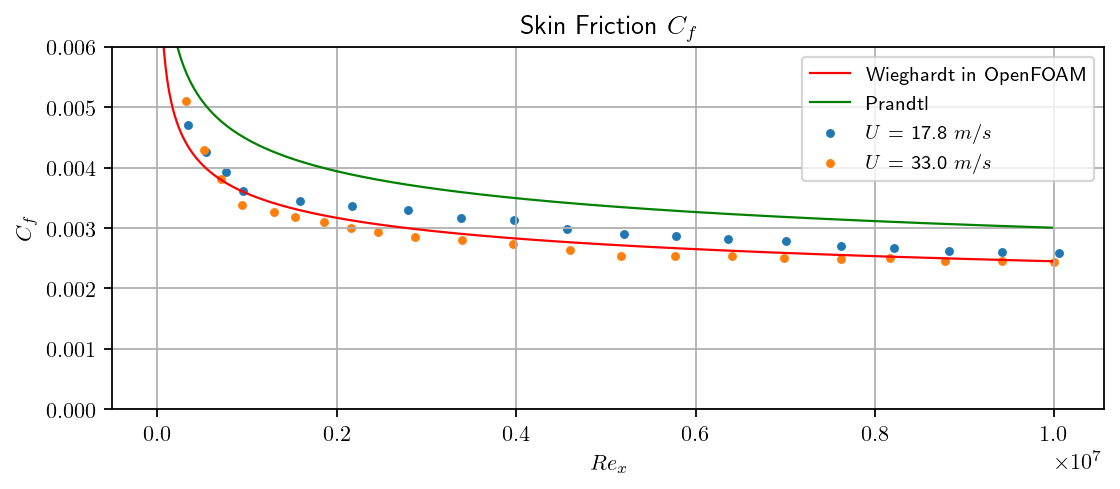

In [9]:
style = ["-", "--", "-.", ":"]
lw = 1.0

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
plt.ylim([0, 0.006])
plt.grid()
ax.set_xlabel(r"$Re_x$")
ax.set_ylabel(r"$C_f$")
plt.title(r"Skin Friction $C_f$")
ax.scatter(Rex1, Cf1, label = "$U$ = 17.8 $m/s$", marker = ".", c = "C{:d}".format(0), lw = lw)
ax.scatter(Rex2, Cf2, label = "$U$ = 33.0 $m/s$", marker = ".", c = "C{:d}".format(1), lw = lw)
ax.plot(Rex, wieghardt, color = "r", label = "Wieghardt in OpenFOAM", lw = lw)
ax.plot(Rex, prandtl, color = "g", label = "Prandtl", lw = lw)
ax.legend(fontsize = 9)

## **6-1. Functions for a Regression Method**

In [10]:
def PrandtlEq (Rex, m, p, n):
    c_f = m*(np.log10(Rex) + p)**(-n)
    return c_f

def CostFunc (c_f1, Cf1, c_f2, Cf2):
    train_m1 = len(c_f1)
    train_m2 = len(c_f2)
    cost = 1/(2*train_m1)*np.dot(c_f1 - Cf1, c_f1 - Cf1) + 1/(2*train_m2)*np.dot(c_f2 - Cf2, c_f2 - Cf2)
    return cost

def dJdm (c_f1, Cf1, c_f2, Cf2, Rex1, Rex2, m, p, n):
    train_m1 = len(c_f1)
    train_m2 = len(c_f2)
    dm = (1/train_m1)*np.dot(c_f1 - Cf1, (np.log10(Rex1) + p)**(-n)) + (1/train_m2)*np.dot(c_f2 - Cf2, (np.log10(Rex2) + p)**(-n))
    return dm

def dJdp (c_f1, Cf1, c_f2, Cf2, Rex1, Rex2, m, p, n):
    train_m1 = len(c_f1)
    train_m2 = len(c_f2)
    dp = (1/train_m1)*np.dot(c_f1 - Cf1, m*(-n)*(np.log10(Rex1) + p)**(-n-1)) + (1/train_m2)*np.dot(c_f2 - Cf2, m*(-n)*(np.log10(Rex2) + p)**(-n-1))
    return dp

def dJdn (c_f1, Cf1, c_f2, Cf2, Rex1, Rex2, m, p, n):
    train_m1 = len(c_f1)
    train_m2 = len(c_f2)
    dn = (1/train_m1)*np.dot(c_f1 - Cf1, m*(-np.log(np.log10(Rex1) + p))*((np.log10(Rex1) + p)**(-n))) + (1/train_m2)*np.dot(c_f2 - Cf2, m*(-np.log(np.log10(Rex2) + p))*((np.log10(Rex2) + p)**(-n)))
    return dn

## **6-2. Execution of the Regression Method**

Both experimental data 1 and 2 are used to calculate the cost function. Therefore, the regression method also uses both of data. Even though p is fixed to 0, a number of local minima exist.

In [11]:
# Fix p = 0
m = 0.400
p = 0
n = 2.0
alpha_m = 10
#alpha_p = 1
alpha_n = 50

oldcost = 0
cost = 1
epoch = 0

while(abs(cost - oldcost) > 1e-12):
    c_f1 = PrandtlEq(Rex1, m, p, n)
    c_f2 = PrandtlEq(Rex2, m, p, n)
    oldcost = cost
    m -= alpha_m*dJdm(c_f1, Cf1, c_f2, Cf2, Rex1, Rex2, m, p, n)
    #p -= alpha_p*dJdp(c_f1, Cf1, c_f2, Cf2, Rex1, Rex2, m, p, n)
    n -= alpha_n*dJdn(c_f1, Cf1, c_f2, Cf2, Rex1, Rex2, m, p, n)
    cost = CostFunc(c_f1, Cf1, c_f2, Cf2)
    epoch += 1    
    if (epoch%1000 == 0):
        print(abs(cost - oldcost))

print("epoch :{}, m : {}, p : {}, n : {}, cost : {}".format(epoch, m, p, n, cost))

epoch :824, m : 0.2709755833762757, p : 0, n : 2.400610384043095, cost : 3.5019688207787365e-08


## **6-3. Execution of Brute Force Method**

We check the cost for all the list of m, p, and n by using brute force method. The range of each list is based on the two references of the equation in *Wieghardt(1944)* and in **OpenFOAM**. This method is more suitable to find the minimum cost value than the regression method.

In [12]:
m_list = [0.455 - 0.01*i for i in range(20)]
print("m : {}".format(m_list))
p_list = [-0.1 + 0.01*j for j in range(20)]
print("\np : {}".format(p_list))
n_list = [2.60 - 0.01*k for k in range(20)]
print("\nn : {}\n".format(n_list))

# Create a three dimensional matrix to find each index for minimum cost value
cost_list = np.zeros(len(m_list)*len(p_list)*len(n_list),)
cost_list = cost_list.reshape(len(m_list), len(p_list), len(n_list))
print(cost_list.shape)

m : [0.455, 0.445, 0.435, 0.42500000000000004, 0.41500000000000004, 0.405, 0.395, 0.385, 0.375, 0.365, 0.355, 0.34500000000000003, 0.335, 0.325, 0.315, 0.30500000000000005, 0.29500000000000004, 0.28500000000000003, 0.275, 0.265]

p : [-0.1, -0.09000000000000001, -0.08, -0.07, -0.060000000000000005, -0.05, -0.04000000000000001, -0.03, -0.020000000000000004, -0.010000000000000009, 0.0, 0.009999999999999995, 0.01999999999999999, 0.03, 0.04000000000000001, 0.04999999999999999, 0.06, 0.07, 0.07999999999999999, 0.09]

n : [2.6, 2.5900000000000003, 2.58, 2.5700000000000003, 2.56, 2.5500000000000003, 2.54, 2.5300000000000002, 2.52, 2.5100000000000002, 2.5, 2.49, 2.48, 2.47, 2.46, 2.45, 2.44, 2.43, 2.42, 2.41]

(20, 20, 20)


In [13]:
# Brute Force
for k in range(len(n_list)):
    for j in range(len(p_list)):
        for i in range(len(m_list)):
            c_f_brute1 = PrandtlEq(Rex1, m_list[i], p_list[j], n_list[k])
            c_f_brute2 = PrandtlEq(Rex2, m_list[i], p_list[j], n_list[k])
            cost_list[i][j][k] = CostFunc(c_f_brute1, Cf1, c_f_brute2, Cf2)

# Find indices for a multiple dimensional matrix
min_index = np.unravel_index(np.argmin(cost_list, axis=None), cost_list.shape)
print(min_index)

(8, 0, 0)


In [14]:
print("The m, p, n values with respect to the minimum cost value.")
print("m = {}".format(m_list[min_index[0]]))
print("p = {}".format(p_list[min_index[1]]))
print("n = {}".format(n_list[min_index[2]]))
print("Cost = {}".format(CostFunc(PrandtlEq(Rex1, m_list[min_index[0]], p_list[min_index[1]], n_list[min_index[2]]), Cf1, PrandtlEq(Rex2, m_list[min_index[0]], p_list[min_index[1]], n_list[min_index[2]]), Cf2)))

The m, p, n values with respect to the minimum cost value.
m = 0.375
p = -0.1
n = 2.6
Cost = 3.049977913346295e-08


## **7-1. Plot the Regression Curve with the Experimental Data Curve**

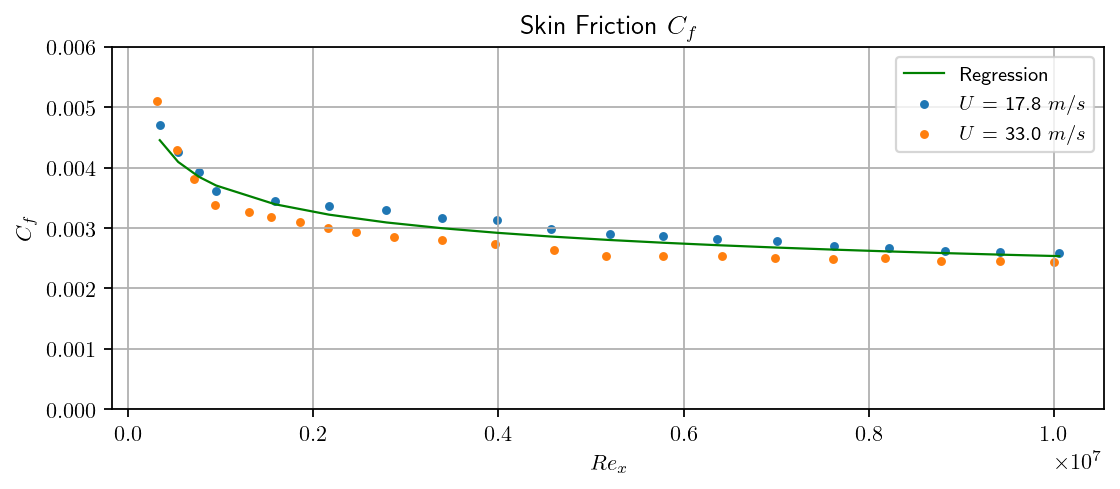

In [15]:
style2 = ["-", "--", "-.", ":"]
lw2 = 1.0

fig2, ax2 = plt.subplots(1, 1, figsize=(8, 3))
plt.ylim([0, 0.006])
plt.grid()
ax2.set_xlabel(r"$Re_x$")
ax2.set_ylabel(r"$C_f$")
plt.title(r"Skin Friction $C_f$")
ax2.scatter(Rex1, Cf1, label = "$U$ = 17.8 $m/s$", marker = ".", c = "C{:d}".format(0), lw = lw2)
ax2.scatter(Rex2, Cf2, label = "$U$ = 33.0 $m/s$", marker = ".", c = "C{:d}".format(1), lw = lw2)
ax2.plot(Rex1, PrandtlEq(Rex1, m, p, n), label = "Regression", ls = style2[0], c = 'g', lw = lw2)
ax2.legend(fontsize = 9)

## **7-2. Plot for Brute Force Method**

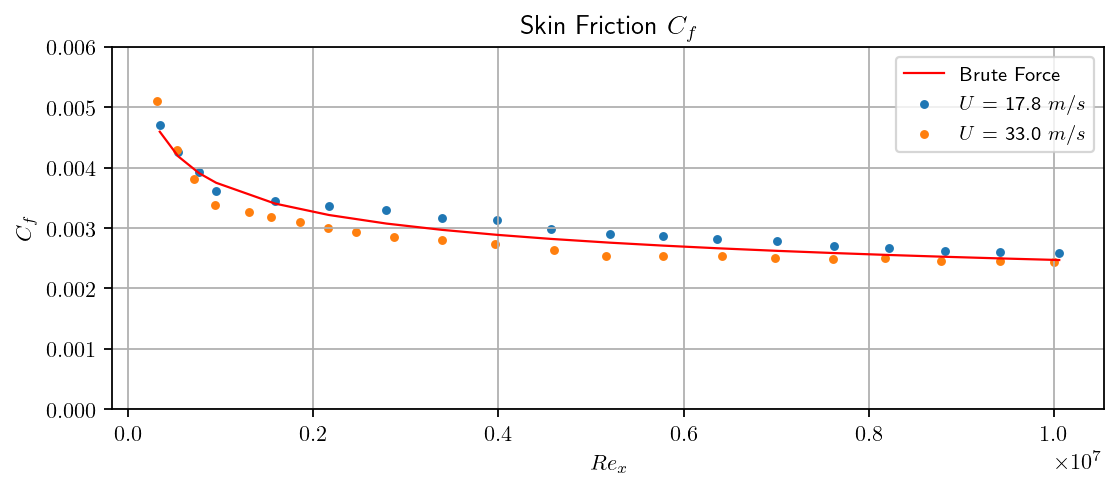

In [16]:
style3 = ["-", "--", "-.", ":"]
lw3 = 1.0

fig3, ax3 = plt.subplots(1, 1, figsize=(8, 3))
plt.ylim([0, 0.006])
plt.grid()
ax3.set_xlabel(r"$Re_x$")
ax3.set_ylabel(r"$C_f$")
plt.title(r"Skin Friction $C_f$")
ax3.scatter(Rex1, Cf1, label = "$U$ = 17.8 $m/s$", marker = ".", c = "C{:d}".format(0), lw = lw3)
ax3.scatter(Rex2, Cf2, label = "$U$ = 33.0 $m/s$", marker = ".", c = "C{:d}".format(1), lw = lw3)
ax3.plot(Rex1, PrandtlEq(Rex1, m_list[min_index[0]], p_list[min_index[1]], n_list[min_index[2]]), label = "Brute Force", ls = style3[0], c = 'r', lw = lw3)
ax3.legend(fontsize = 9)